In [1]:
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOTWTUZ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOTWTUZ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [2]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask


In [3]:
train_dataset = dataset["train"].map(load_image_train)
test_dataset = dataset["test"].map(load_image_test)

In [4]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

<Figure size 1500x1500 with 0 Axes>

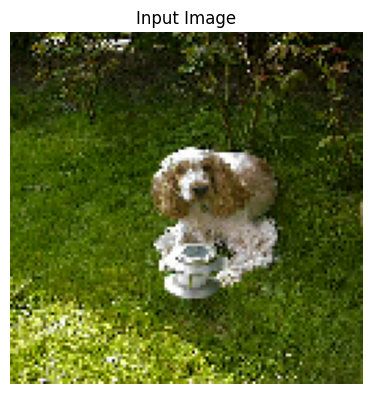

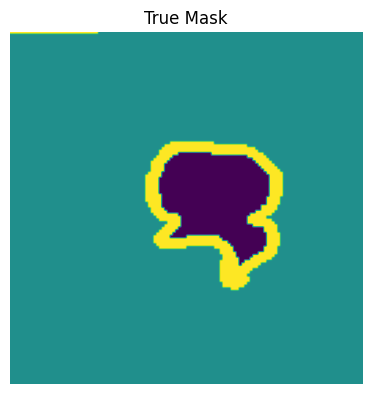

In [5]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.figure(figsize=(10,20))
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [6]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [7]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x


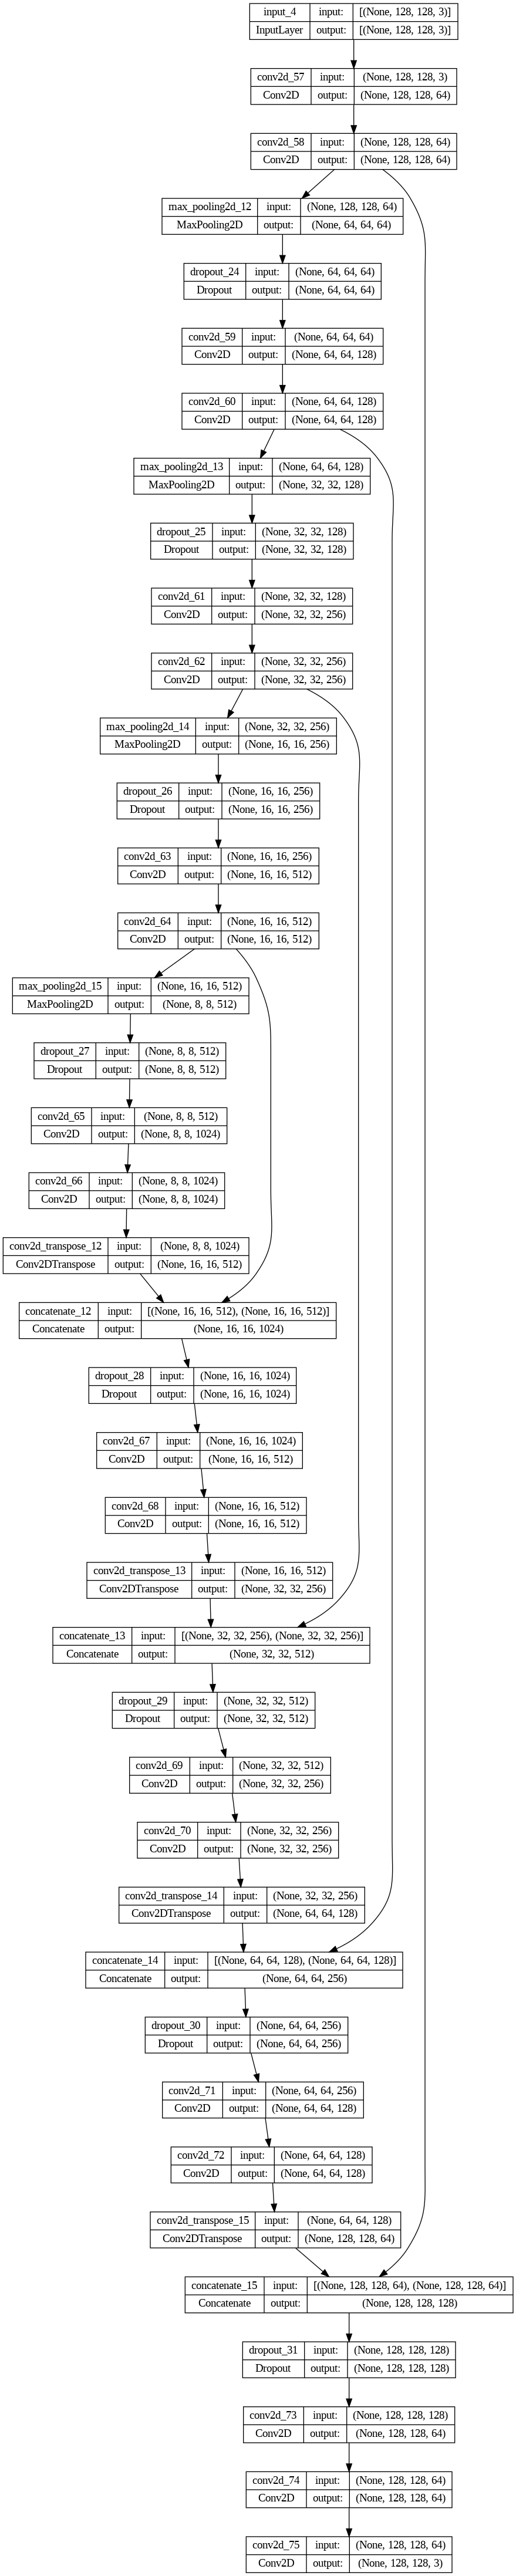

In [12]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)
bottleneck = double_conv_block(p4, 1024)
u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
keras.utils.plot_model(unet_model,show_shapes=True)

In [13]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.5863

57/57 [==============================] - 123s 1s/step - loss: 0.9253 - accuracy: 0.5863 - val_loss: 0.8832 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 69s 968ms/step - loss: 0.8551 - accuracy: 0.6054
Epoch 3/20
57/57 [==============================] - 55s 959ms/step - loss: 0.7655 - accuracy: 0.6454
Epoch 4/20
57/57 [==============================] - 54s 956ms/step - loss: 0.6776 - accuracy: 0.7130
Epoch 5/20
57/57 [==============================] - 55s 957ms/step - loss: 0.6069 - accuracy: 0.7552
Epoch 6/20
57/57 [==============================] - 55s 957ms/step - loss: 0.5392 - accuracy: 0.7865
Epoch 7/20
57/57 [==============================] - 55s 959ms/step - loss: 0.4949 - accuracy: 0.8068
Epoch 8/20
57/57 [==============================] - 55s 958ms/step - loss: 0.4523 - accuracy: 0.8243
Epoch 9/20
57/57 [==============================] - 55s 958ms/step - loss: 0.4203 - accuracy: 0.8377
Epoch 10/20
57/57 [==============================] - 55s 959ms

(128, 128, 1)
1/1 [==============================] - 0s 19ms/step


<Figure size 1500x1500 with 0 Axes>

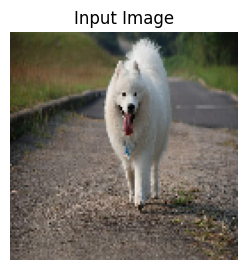

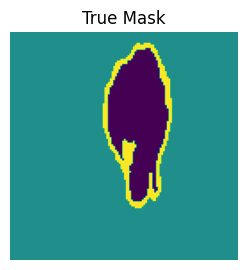

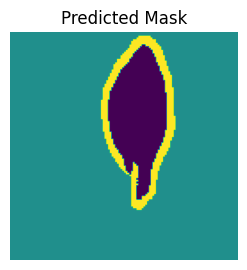

In [37]:
sample = next(iter(train_batches))
print(sample[1][0].shape)
jj=sample[0][0][np.newaxis,...]
pred_mask = unet_model.predict(jj)
pred_mask = np.argmax(pred_mask, axis=-1)
pre=pred_mask[0][...,np.newaxis]
display([sample[0][0], sample[1][0],pre])


1/1 [==============================] - 23s 23s/step


<Figure size 1500x1500 with 0 Axes>

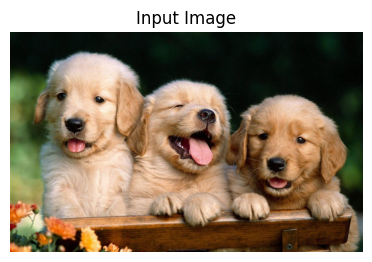

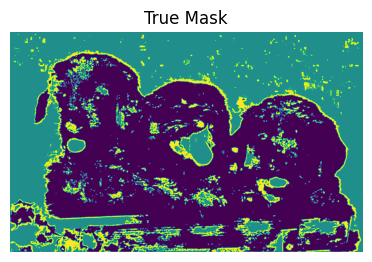

In [59]:
img1=keras.utils.load_img("/content/dog-wj7msvc5kj9v6cyy.jpg")
ar1=keras.utils.img_to_array(img1)
jj=ar1[np.newaxis,...]
pred_mask = unet_model.predict(jj)
pred_mask = np.argmax(pred_mask, axis=-1)
pre=pred_mask[0][...,np.newaxis]
display([img1,pre])